In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
# Load the data
df = pd.read_csv(r'C:\Users\Siddharth\Desktop\Projects\TSP 1\Car Sales Data.csv', sep=',')
df.head()

,date,Vehicles Sold
0,2015-04-01,49
1,2015-04-02,58
2,2015-04-03,36
3,2015-04-04,44
4,2015-04-05,64


In [3]:
#Checking any imming entry/ value
df.isnull().sum()

date             0
Vehicles Sold    0
dtype: int64

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2018-06-11'].reset_index(drop=False)                         
test_df = temp_df.loc['2018-06-12':].reset_index(drop=False)
train_df.head()

,date,Vehicles Sold,year,month,day,weekday
0,2015-04-01,49,2015,4,1,2
1,2015-04-02,58,2015,4,2,3
2,2015-04-03,36,2015,4,3,4
3,2015-04-04,44,2015,4,4,5
4,2015-04-05,64,2015,4,5,6


In [5]:
test_df.head()

,date,Vehicles Sold,year,month,day,weekday
0,2018-06-12,35,2018,6,12,1
1,2018-06-13,37,2018,6,13,2
2,2018-06-14,56,2018,6,14,3
3,2018-06-15,47,2018,6,15,4
4,2018-06-16,48,2018,6,16,5


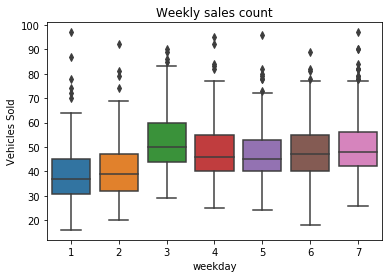

In [6]:
plot = sn.boxplot(x='weekday', y='Vehicles Sold', data=df)
_ = plot.set(title='Weekly sales count')

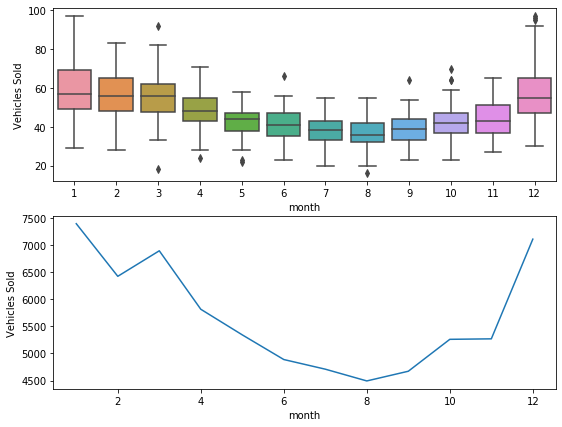

In [7]:
monthly_agg = df.groupby('month')['Vehicles Sold'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='Vehicles Sold', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='Vehicles Sold', data=monthly_agg, ax=axs[1])

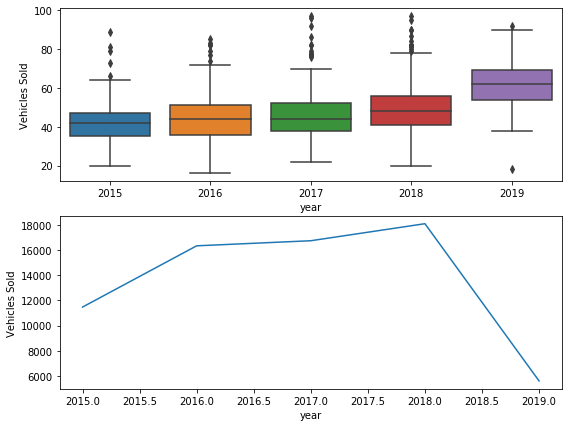

In [8]:
yearly_agg = df.groupby('year')['Vehicles Sold'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='Vehicles Sold', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='Vehicles Sold', data=yearly_agg, ax=axs[1])

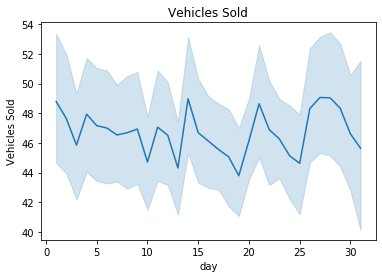

In [9]:
plot = sn.lineplot(x='day', y='Vehicles Sold', data=df)
_ = plot.set(title='Vehicles Sold')

In [10]:
#SEASONAL NAIVE
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_count = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['Vehicles Sold'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('Vehicles Sold', axis=1)
sn_pred_df['seasonal_naive_count'] = pd.DataFrame(seasonal_naive_count).set_index(test_df.index)
sn_pred_df.head()

,date,year,month,day,weekday,seasonal_naive_count
0,2018-06-12,2018,6,12,1,41
1,2018-06-13,2018,6,13,2,23
2,2018-06-14,2018,6,14,3,37
3,2018-06-15,2018,6,15,4,52
4,2018-06-16,2018,6,16,5,31


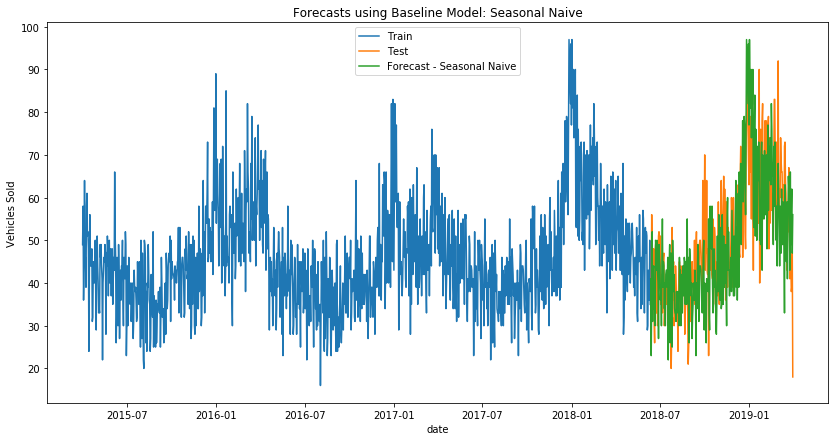

In [11]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['Vehicles Sold'], label='Train')
plt.plot(test_df['date'], test_df['Vehicles Sold'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_count'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('Vehicles Sold')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

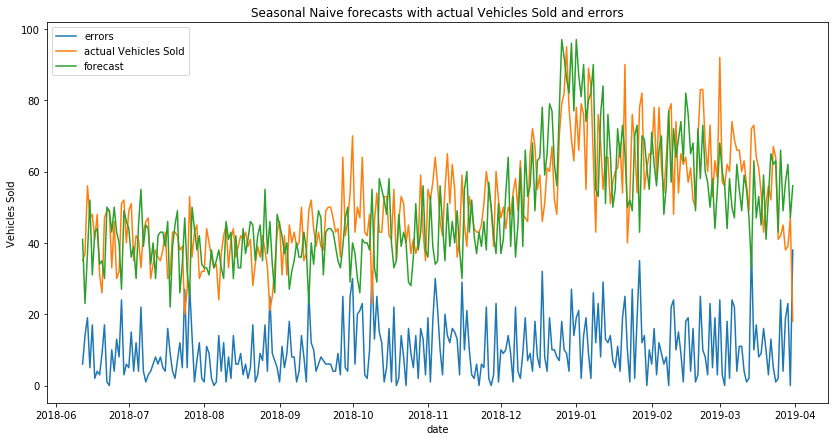

,total_count,total_sn_pred_count,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,14829,14464,365,10.34471,13.197502,20.439679


In [12]:
#ERROR ANALYSIS IN NAIVE
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'Vehicles Sold', 'seasonal_naive_count']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'Vehicles Sold', 'seasonal_naive_count']]
errors_df['errors'] = test_df['Vehicles Sold'] - sn_pred_df['seasonal_naive_count']
errors_df.insert(0, 'model', 'Seasonal Naive') 

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, count=errors_df['Vehicles Sold']):
    return np.sum(np.abs(err))/np.sum(count) * 100


result_df = errors_df.groupby('model').agg(total_count=('Vehicles Sold', 'sum'),
                                           total_sn_pred_count=('seasonal_naive_count', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))
    

plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['Vehicles Sold'], label='actual Vehicles Sold')
plt.plot(errors_df['date'], errors_df['seasonal_naive_count'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('Vehicles Sold')
plt.title('Seasonal Naive forecasts with actual Vehicles Sold and errors')
plt.show()

result_df

In [13]:
#TIME SERIES DECOMPOSITION
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['Vehicles Sold'] = ts_decomp_df['Vehicles Sold'].astype(int)
ts_decomp_df.head()

,Vehicles Sold,year,month,day,weekday
date,,,,,
2015-04-01,49,2015,4,1,2
2015-04-02,58,2015,4,2,3
2015-04-03,36,2015,4,3,4
2015-04-04,44,2015,4,4,5
2015-04-05,64,2015,4,5,6


<Figure size 432x288 with 0 Axes>

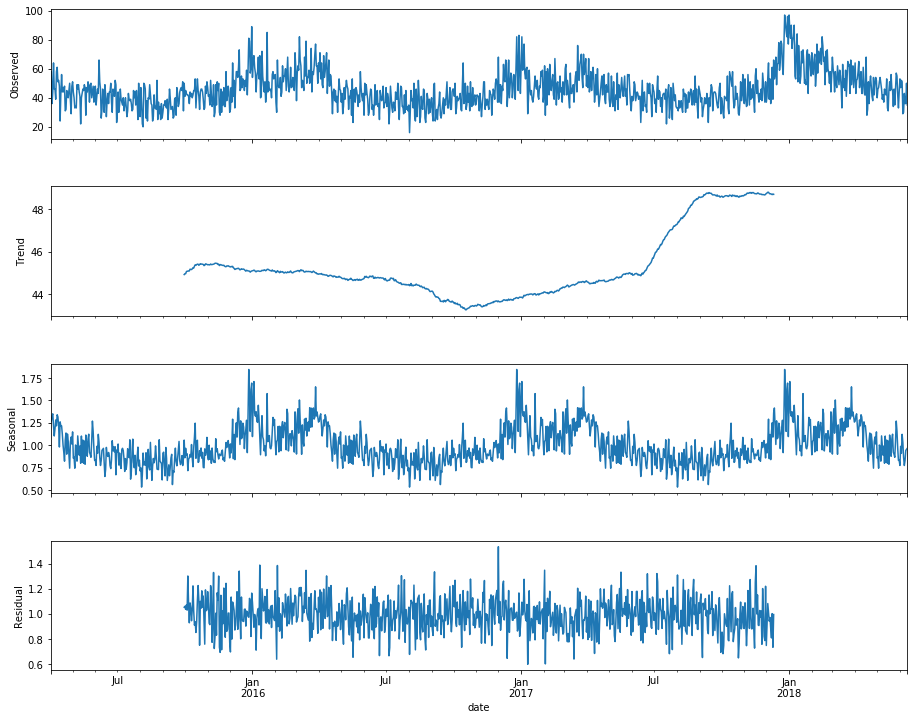

In [14]:
#TIME SERIES DECOMPOSITION PLOT
result = seasonal_decompose(ts_decomp_df['Vehicles Sold'], model='multiplicative', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

<Figure size 432x288 with 0 Axes>

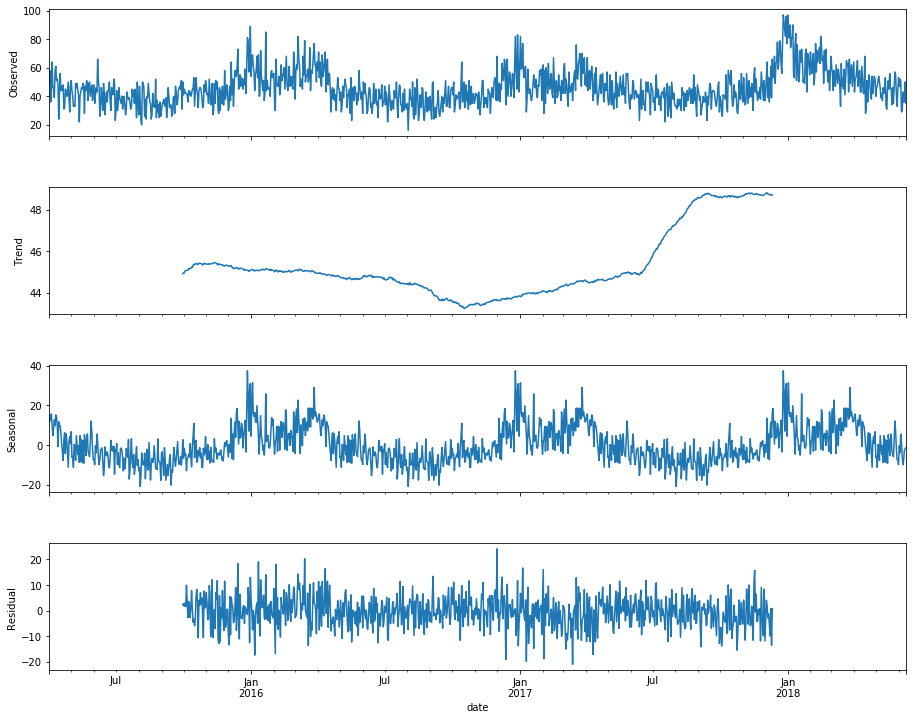

In [15]:
result = seasonal_decompose(ts_decomp_df['Vehicles Sold'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

In [16]:
hw_train_df = train_df[['date', 'Vehicles Sold']].set_index('date')
hw_test_df = test_df[['date', 'Vehicles Sold']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_count').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_count').reset_index()
print('Forecasts made, ready for evaluation')

Forecasts made, ready for evaluation


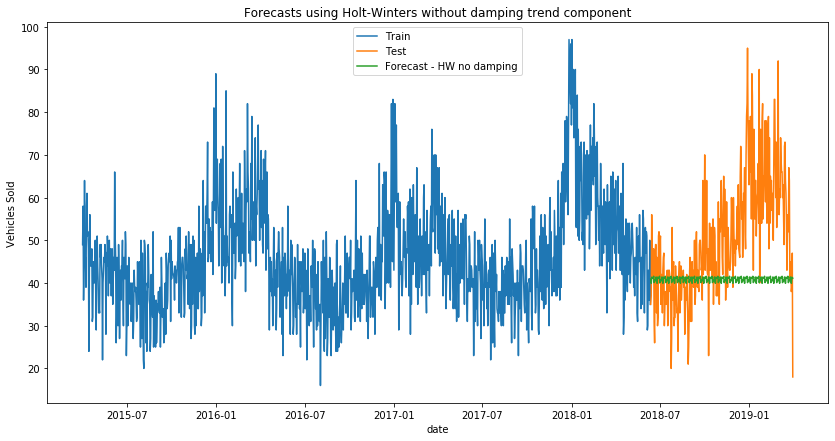

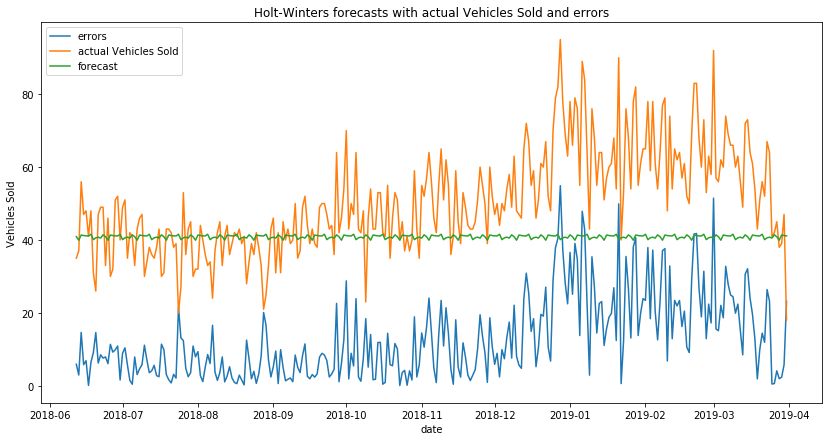

,total_count,total_pred_count,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,14829,11979.334347,2849.665653,12.904818,17.166562,25.498089


In [17]:

# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'Vehicles Sold', 'pred_count']]
errors_df_hw['errors'] = errors_df_hw['Vehicles Sold'] - errors_df_hw.pred_count
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['Vehicles Sold'], label='Train')
plt.plot(test_df['date'], test_df['Vehicles Sold'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_count'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('Vehicles Sold')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['Vehicles Sold'], label='actual Vehicles Sold')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_count'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('Vehicles Sold')
plt.title('Holt-Winters forecasts with actual Vehicles Sold and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_count=('Vehicles Sold', 'sum'),
                                          total_pred_count=('pred_count', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw


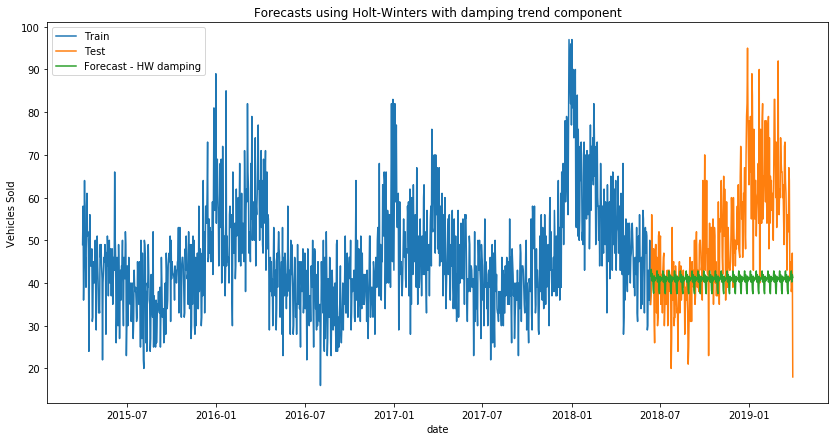

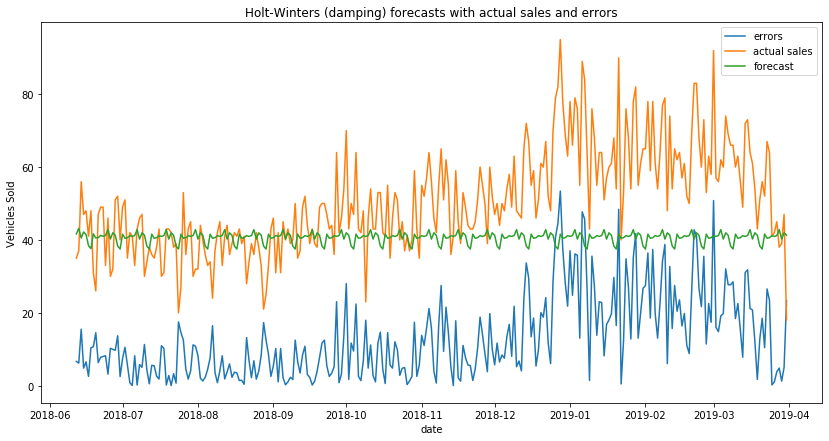

,total_count,total_pred_count,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,14829,11924.232938,2904.767062,13.061377,17.344812,25.807428


In [18]:
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'Vehicles Sold','pred_count']]
errors_df_hwd['errors'] = errors_df_hwd['Vehicles Sold'] - errors_df_hwd.pred_count
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped') 


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['Vehicles Sold'], label='Train')
plt.plot(test_df['date'], test_df['Vehicles Sold'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_count'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('Vehicles Sold')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['Vehicles Sold'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_count'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('Vehicles Sold')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_count=('Vehicles Sold', 'sum'),
                                          total_pred_count=('pred_count', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hwd


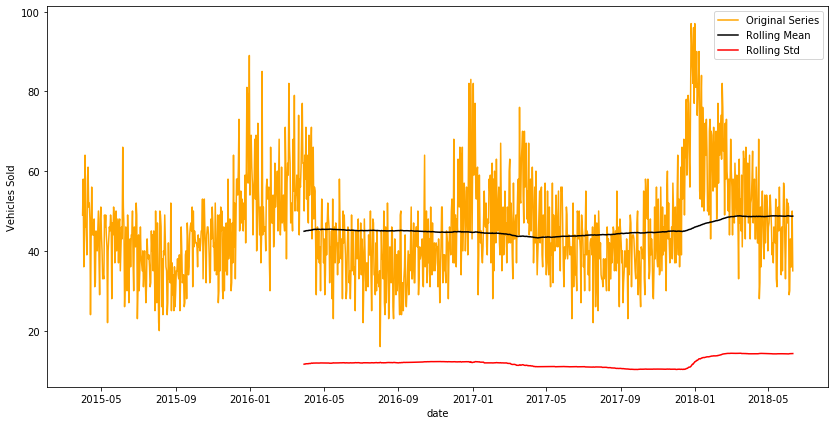

Test statistic = -3.348
P-value = 0.013
Critical values :
	1%: -3.436079050499444 - The data is not stationary with 99% confidence
	5%: -2.8640697479399972 - The data is  stationary with 95% confidence
	10%: -2.5681169015905425 - The data is  stationary with 90% confidence


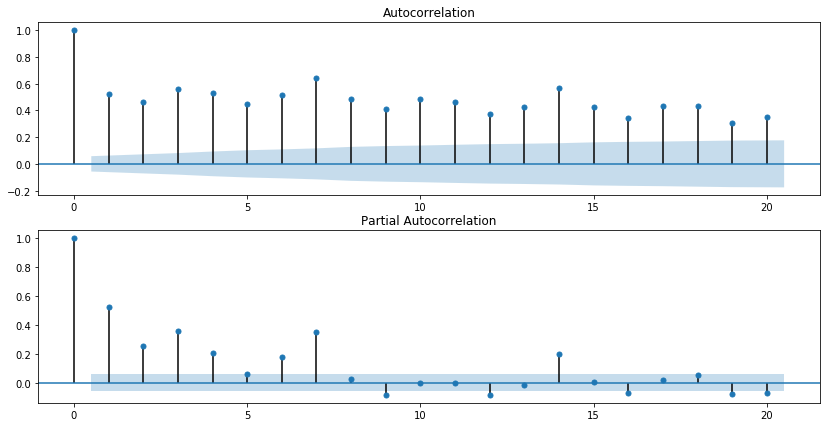

In [19]:
arima_df = train_df[['date', 'Vehicles Sold']].set_index('date')
arima_test_df = test_df[['date', 'Vehicles Sold']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='orange', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('Vehicles Sold')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df['Vehicles Sold'])


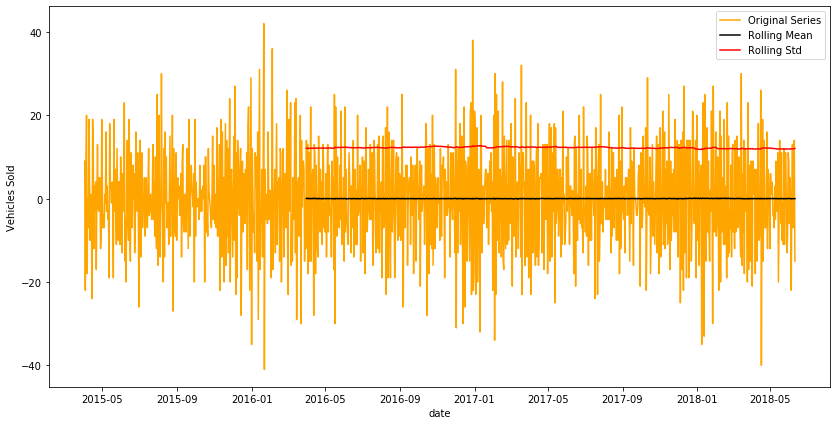

Test statistic = -7.864
P-value = 0.000
Critical values :
	1%: -3.436079050499444 - The data is  stationary with 99% confidence
	5%: -2.8640697479399972 - The data is  stationary with 95% confidence
	10%: -2.5681169015905425 - The data is  stationary with 90% confidence


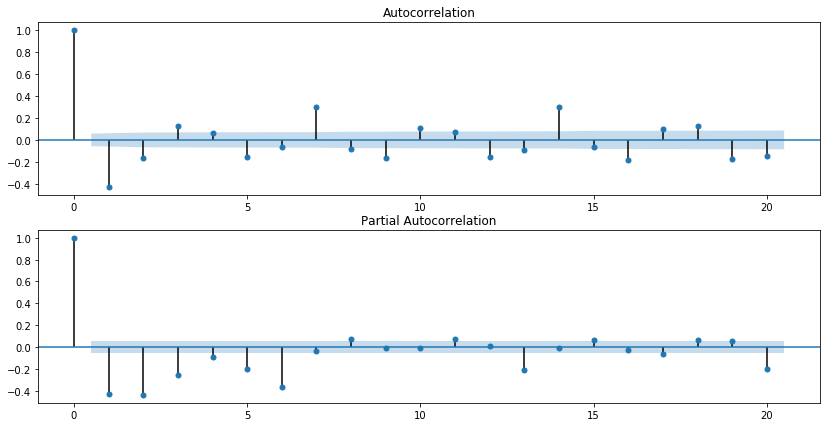

In [20]:
first_difference = arima_df['Vehicles Sold'] - arima_df['Vehicles Sold'].shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference['Vehicles Sold'])

In [21]:
arima_model61 = ARIMA(arima_df['Vehicles Sold'], (7,1,1)).fit(disp=False)
print(arima_model61.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.Vehicles Sold   No. Observations:                 1167
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -4166.852
Method:                       css-mle   S.D. of innovations              8.592
Date:                Fri, 05 Jun 2020   AIC                           8353.704
Time:                        08:46:04   BIC                           8404.326
Sample:                    04-02-2015   HQIC                          8372.799
                         - 06-11-2018                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0093      0.053     -0.174      0.862      -0.114       0.095
ar.L1.D.Vehicles Sold    -1.5671      0.182     -8.598      0.000      -1.924      -1.210
ar.L2.D.

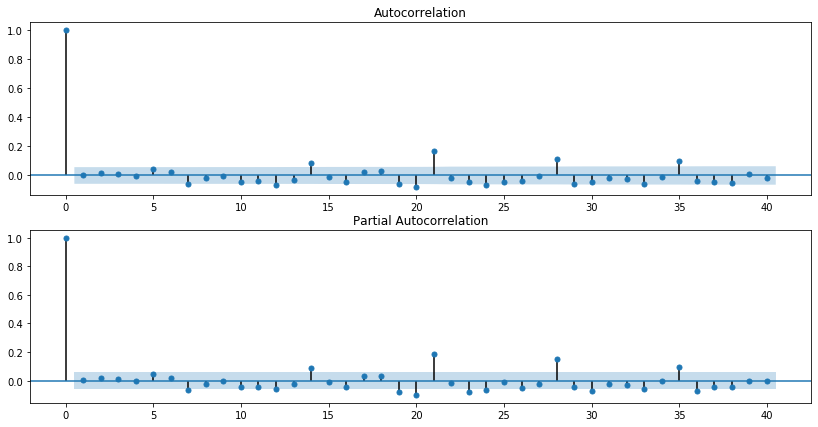

In [22]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

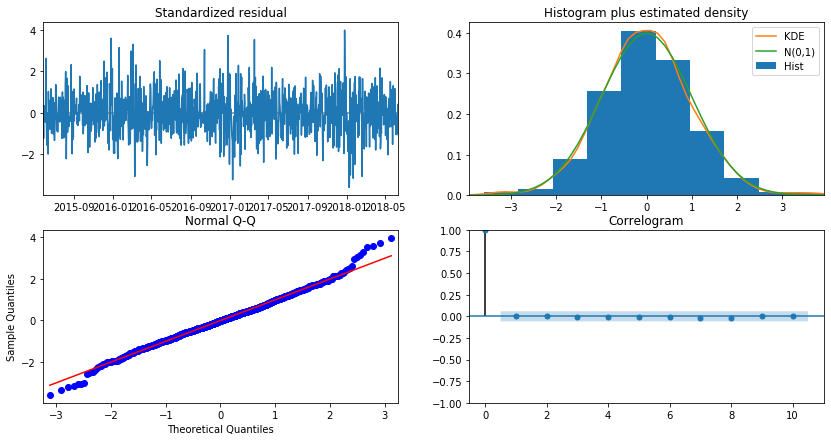

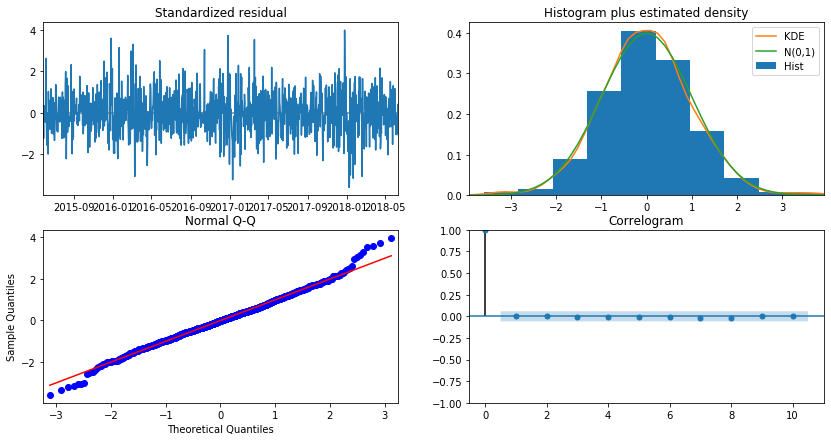

In [23]:
# fit the model
sarima_model = SARIMAX(arima_df['Vehicles Sold'], order=(7, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_count'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot